# CM3015, MLNN, End of term coursework submission [002]

```
Hudson Leonardo MENDES
(hlm12@student.london.ac.uk)
Unversity of London
2023
```


## Introduction

The present report utilises the **Universal Workflow of Machine Learning**[<a href="#ref-fc-dlwp">1</a>] to produce<br />
a _"Final Model"_ that produces the best results found through thorough investigation on<br />
the **`CIFAR10`** dataset using exclusively `Dense` and `Dropout` layers as required by the<br />
coursework instructions.

Such _"Final Model"_ resulted in `53.58%` validation accuracy (up from `25.28%` validation accuracy<br />
from the _"Baseline Model"_ (first model with statistical power[<a href="#ref-fc-dlwp">1</a>], i.e. > `10%` on `CIFAR10` which has<br />
10 classes.), also performing at `54.24%` accuracy on the **`test` split** as a final, after re-training<br />
both the **`train`** and **`valid` split**, confirming that its generalisation power was preserved over unseen data.

Even though `50%` accuracy is rarely sufficient for commercial applications, given that it performs<br />
well under the _Bayes error rate_[<a href="#ref-tg-etbertcc">2</a>] for classification, the present work details what a thorough<br />
investigation has demonstrated that this accuracy could possibly be the limits of modeling<br />
restricted exclusively with the layer types allowed, the size of the data available, as well<br />
as the computing powerat disposal (although **Data Augmentation** was not attempted could<br />
also possibly increase performance[<a href="#ref-yxzgzs-idafdlas">5</a>]).

The result section presents a tabulated version of all the results which then led to the conclusions<br />
presented in the final section, demonstrating how overitting models compared to the final model as<br />
as as their baseline counterparts, with notes about each of their architectures.

## Settings

We initially define some hyperparameters used by default as training settings.<br />
Not all hyper parameters are defined below, because some of them (e.g.: `learning_rate`)<br />
are far too specific to some components of the architecture (e.g.: the `optimiser`).


In [1]:
# Sets the default hyperparameters used for training
# These can be overridden by passsing the hyperparam names
# as keyword arguments to the experiment class constructor
train_hyperparams = dict(
    epochs=100,
    batch_size=512,
)


## Environment

The following section installs the required dependencies used while running<br />
the experimentation with **Tensorflow** and **Keras**.<br />

Due to the fact we run the present notebook in **Google Colab**, this section<br />
also connects to Google Drive in order to save logs (CSV, Tensorboard), as well<br />
as a `saved_model` snapshot of the _"Final Model"_.


In [2]:
%%capture
%pip install matplotlib
%pip install tensorflow
%pip install -U tfds-nightly
%pip install -U tqdm

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import (
    models,
    layers,
    losses,
    optimizers,
    regularizers,
    callbacks,
)

(tf.__version__, tf.keras.__version__, tfds.__version__)


2023-02-28 16:39:36.623336: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/hudsonmendes/Workspaces/hudsonmendes-estudos/cm3015-mlnn/final/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('2.11.0', '2.11.0', '4.8.2+nightly')

In [4]:
from typing import List, Dict, Tuple, Callable, Union, Optional, Any


In [6]:
import functools
import itertools
import os

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


In [6]:
from google.colab import drive

drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 1. Problem & Dataset

Classifying raw images into categories is an extremely valuable task, with applications<br />
across industries[<a href="#ref-cwg-asotaoicbocnn">3</a>].

A classic instance of image classification problems is what can be described as a<br />
**multi-class, single-label classification** problem, where $K$ labels exist and each<br />
document (in this case an image) will have a single class attributed (or "labelled") to it.

Formally:

* $\hat{y} = f(X) = \textbf{argmax } g(\theta, X)_{[k]}, \forall{k \in K=\{ 0...|classes| \}}$, where:
    * $X$ is the input image
    * $f$ is the labeller function
    * $g$ is the model
    * $\theta$ are the trainable parameters of the model


The present work utilises the `CIFAR10` dataset available in the **Tensorflow Datasets Catalog**[<a href="#ref-ciar10">4</a>],<br />
which is an example of such a problem: one of the 1 out of 10 classes must be assigned to each<br />
one of the 10,000 test images.

As per its own description:
> "The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images."

In [7]:
ds, ds_info = tfds.load("cifar10", with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteOYAS1L/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteOYAS1L/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [8]:
ds_image_dims = functools.reduce(lambda x, y: x * y, ds_info.features["image"].shape)
ds_image_dims


3072

In [9]:
ds_classes = ds_info.features["label"].num_classes
ds_classes


10

In [10]:
ds_info.description


'The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.'

,id,image,label
0,train_16399,,7 (horse)
1,train_01680,,8 (ship)
2,train_47917,,4 (deer)
3,train_17307,,4 (deer)
4,train_27051,,6 (frog)
5,train_48736,,5 (dog)
6,train_26263,,2 (bird)
7,train_01456,,9 (truck)
8,train_19135,,6 (frog)
9,train_31598,,6 (frog)

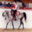
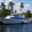
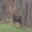
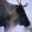
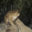
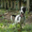
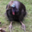
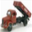
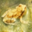
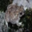

In [11]:
tfds.as_dataframe(ds["train"].take(10), ds_info)


## Step 2. Measure of Success

The number of examples per class is balanced, allowing the `accuracy` metric to be<br />
suitable. The **`accuracy score`**, (higher=better) is given by the following equation:

$Accuracy = \frac{Correct}{Total} = \frac{TP + TN}{TP + FP + TN + FN}$

The one-hot encoded vector of the ground-truth, as well as the vector of softmax<br />
output provide us with probability distributions. And given that we have 2 probability<br />
distributions, we can use the differentiable loss function called **`cross entropy loss`**<br />
to calculate the error in our prediction.

$CCE = L(y, \hat{y}) = -\sum^{N}_{n=1}\sum^{K}_{k=1} y_{nk} \log{\hat{y}_{nk}}$, where:
* $y$ is a vector representing the one-hot encoded label
* $\hat{y}$ is a vector of the probability distribution output either by a `softmax` output, or similar

By minimising $CCE$, we fit a model that will produce a $\hat{y}$ the is the closest<br />
possible to the ground-truth $y$.

**Important:** in order to use the `categorical_crossentropy` loss function, the<br />
ground-truth labels must be one-hot encoded first. Alternatively, the<br />
`sparse_categorical_crossentropy` could have been used.

In [9]:
cce = losses.CategoricalCrossentropy()
[
    cce(y_true=np.array([0., 0., 1., 0.]), y_pred=np.array([0., 0., 1., 0.])),
    cce(y_true=np.array([0., 0., 1., 0.]), y_pred=np.array([0., 1., 0., 0.])),
    cce(y_true=np.array([0., 0., 1., 0.]), y_pred=np.array([0., 0.5, 0.5, 0.])),
]

[<tf.Tensor: shape=(), dtype=float64, numpy=1.0000000494736474e-07>,
 <tf.Tensor: shape=(), dtype=float64, numpy=16.11809565095832>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.6931471805599453>]

## Step 3. Evaluation Protocol

`<tbd>`


In [12]:
tfds.load("cifar10", split=("train[:80%]", "train[80%:]", "test"), as_supervised=True)


(<PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [13]:
def get_training_data() -> tfds.Split:
    """
    Returns a split of the training dataset with first 80% of the data
    and featuring the `image` and `label`.
    :return: A split of the training dataset to be used for training.
    """
    return tfds.load("cifar10", split="train[:80%]", as_supervised=True)


In [14]:
def get_validation_data() -> tfds.Split:
    """
    Returns a split of the training dataset with last 20% of the data
    and featuring the `image` and `label`.
    :return: A split of the training dataset that can be used for validation.
    """
    return tfds.load("cifar10", split="train[80%:]", as_supervised=True)


In [15]:
def get_training_and_validation_data() -> tfds.Split:
    """
    Returns the entire "training" split of the dataset
    featuring the `image` and `label`.
    :return: A split of the training dataset that can be used for final training
    """
    return tfds.load("cifar10", split="train", as_supervised=True)


In [16]:
def get_test_data() -> tfds.Split:
    """
    Returns the entire "test" split of the dataset
    featuring the `image` and `label`.
    :return: A split of the training dataset that can be used for final testing
    """
    return tfds.load("cifar10", split="test", as_supervised=True)


## Step 4. Data Preparation

`<tbd>`


In [17]:
class Preprocessor:
    """
    Preprocesses the images of the dataset, so that instead
    of the original 32x32x3 images, we have 3072x1 images,
    as well as the labels, which are one-hot encoded.

    :param image_dims: The number of pixels in the image.
    :param n_classes: The number of classes in the dataset.
    :return: A callable that takes an image and a label and
    """

    def __init__(self, image_dims: int, n_classes: int):
        self.image_dims = image_dims
        self.n_classes = n_classes

    def __call__(self, image: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
        """
        Performs the preprocessing.
        :param image: The image to preprocess.
        :param label: The label to preprocess.
        :return: The preprocessed image and label.
        """
        if image.dtype == tf.uint8:
            image = tf.cast(image, tf.float32) / 255.0
            image = tf.reshape(image, (self.image_dims,))
        if label.dtype == tf.int64:
            label = tf.one_hot(label, self.n_classes)
        return image, label


In [18]:
preprocessing_fn = Preprocessor(image_dims=ds_image_dims, n_classes=ds_classes)
preprocessing_fn


## Step 5. Baseline Model

`<tbd>`


In [19]:
class ModelBuilder:
    """
    Builder class for the Image Classification Model that minimizes
    a cross-entropy loss function (default) against the n_classes possible
    classes in the dataset, with the output head being a softmax layer.

    :param input_dims: The number of pixels in the image.
    :param n_classes: The number of classes in the dataset.
    :param optimizer: The optimizer to use for training.
    :param loss: The loss function to use for training.
    :return: the Sequential model, compiled and ready for training.
    """

    optimizer: Union[str, optimizers.Optimizer] = "rmsprop"
    loss: Union[str, losses.Loss] = "categorical_crossentropy"
    log_dir_tensorboard: Optional[str] = None
    log_path_training: Optional[str] = None
    layers: List[
        Tuple[
            int,
            Optional[Union[str, Callable[[tf.Tensor], tf.Tensor]]],
            Optional[Union[str, regularizers.Regularizer]],
            Optional[float],
        ]
    ] = None

    def __init__(
        self,
        input_dims: int,
        n_classes: int,
    ):
        self.input_dims = input_dims
        self.n_classes = n_classes
        self.layers = []

    def add_layer(
        self,
        units: int,
        activation: Optional[Union[str, Callable[[tf.Tensor], tf.Tensor]]] = None,
        regularization: Optional[Union[str, regularizers.Regularizer]] = None,
        dropout: Optional[float] = None,
    ) -> "ModelBuilder":
        """
        Adds a layer to the model.
        :param units: The number of units in the layer.
        :param activation: The activation function to use in the layer.
        :param regularization: The regularization function to use in the layer.
        :param dropout: Whether we must add a dropout layer after the layer
        :return: The model builder.
        """
        self.layers.append((units, activation, regularization, dropout))
        return self

    def with_optimizer(
        self,
        optimizer: Union[str, optimizers.Optimizer],
    ) -> "ModelBuilder":
        """
        Sets the optimizer to use for training, or reverts to the default.
        :param optimizer: The optimizer to use for training.
        :return: The model builder.
        """
        self.optimizer = optimizer
        return self

    def with_loss(
        self,
        loss: Union[str, losses.Loss],
    ) -> "ModelBuilder":
        """
        Sets the loss function to use for training, or reverts to the default.
        :param loss: The loss function to use for training.
        :return: The model builder.
        """
        self.loss = loss
        return self

    def build(self) -> models.Sequential:
        """
        Resets the tensorflow random seed, builds the model, compiles it,
        prints a summary of the model, and returns the model.
        """
        tf.keras.utils.set_random_seed(42)
        model = models.Sequential()
        for i, (u, a, r, d) in enumerate(self.layers):
            if i == 0:
                model.add(
                    layers.Dense(
                        u,
                        activation=a,
                        kernel_regularizer=r,
                        input_shape=(self.input_dims,),
                        name=f"x{i}",
                    )
                )
            else:
                model.add(
                    layers.Dense(
                        u,
                        activation=a,
                        kernel_regularizer=r,
                        name=f"x{i}",
                    )
                )
            if d is not None and d > 0.0:
                model.add(layers.Dropout(d))
        model.add(layers.Dense(self.n_classes, activation="softmax", name="y_hat"))
        model.compile(optimizer=self.optimizer, loss=self.loss, metrics=["acc"])
        model.summary()
        return model


In [38]:
class Experiment:
    """
    Builds an experiment setup to the default hyperparameters, and
    run it against a given model, dataset, and preprocessor.
    :param default_hyperparams: The default hyperparameters to use.
    :param batch_size: The batch size to use for training.
    :param epochs: The number of epochs to use for training.
    :return: The experiment.
    """

    train_data: tfds.Split
    valid_data: Optional[tfds.Split] = None
    preprocessor: Optional[Preprocessor] = None
    log_tensorboard_dirpath: Optional[str] = None
    log_csv_filepath: Optional[str] = None

    def __init__(self, default_hyperparams: Dict[str, Any], **kwargs):
        self.batch_size = kwargs.get("batch_size", default_hyperparams["batch_size"])
        assert self.batch_size > 0, "The `batch_size` must be greater than zero."
        self.epochs = kwargs.get("epochs", default_hyperparams["epochs"])
        assert self.batch_size > 1, "The `epochs` must be greater than 1."

    def with_preprocessor(self, preprocessor: Optional[Preprocessor]) -> "Experiment":
        """
        Sets the preprocessor to use for training, or reverts to the default.
        :param preprocessor: The preprocessor to use for training.
        :return: The experiment.
        """
        self.preprocessor = preprocessor
        return self

    def with_model(self, model: models.Sequential) -> "Experiment":
        """
        Sets the model to use for training.
        :param model: The model to use for training.
        :return: The experiment.
        """
        self.model = model
        return self

    def with_train_data(self, split: tfds.Split) -> "Experiment":
        """
        Sets the training data to use for training.
        :param split: The training data to use for training.
        :return: The experiment.
        """
        self.train_data = split
        return self

    def with_valid_data(self, split: Optional[tfds.Split]) -> "Experiment":
        """
        Sets the validation data to use for validation.
        :param split: The validation data to use for validation.
        :return: The experiment.
        """
        self.valid_data = split
        return self

    def enable_log_tensorboard(self, dirpath: str) -> "Experiment":
        """
        Enables logging to TensorBoard and sets the directory path to use.
        :param dirpath: The directory path to use for logging.
        :return: The experiment.
        """
        self.log_tensorboard_dirpath = dirpath
        return self

    def enable_log_csv(self, filepath: str) -> "Experiment":
        """
        Enables logging to CSV and sets the file path to use.
        :param filepath: The file path to use for logging.
        :return: The experiment.
        """
        filedir = os.path.dirname(filepath)
        if not os.path.isdir(filedir):
            os.makedirs(filedir)
        self.log_csv_filepath = filepath
        return self

    def run(self) -> callbacks.History:
        """
        Runs the experiment, pre-processing the data if a preprocessor is set,
        and logging to TensorBoard and CSV if enabled.
        """
        assert self.model, "The `model` is required."
        assert self.train_data, "The `train_data` is required."
        train_xy = self.train_data
        valid_xy = self.valid_data
        if self.preprocessor:
            train_xy = train_xy.map(self.preprocessor)
            if valid_xy:
                valid_xy = valid_xy.map(self.preprocessor)
        train_xy = train_xy.cache().batch(self.batch_size)
        if valid_xy:
            valid_xy = valid_xy.cache().batch(self.batch_size)
        tf.keras.utils.set_random_seed(42)
        return self.model.fit(
            train_xy,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_data=valid_xy,
            callbacks=self._build_callbacks(),
        )

    def _build_callbacks(self) -> Optional[List[callbacks.Callback]]:
        fit_callbacks = None
        if self.log_tensorboard_dirpath or self.log_csv_filepath:
            fit_callbacks = []
            if self.log_tensorboard_dirpath:
                fit_callbacks.append(
                    callbacks.TensorBoard(
                        log_dir=self.log_tensorboard_dirpath, write_graph=True, write_images=True
                    )
                )
            if self.log_csv_filepath:
                fit_callbacks.append(callbacks.CSVLogger(filename=self.log_csv_filepath))
        return fit_callbacks


In [21]:
def plot_history(history: callbacks.History) -> None:
    metrics = history.history
    acc_train, acc_valid = metrics["acc"], metrics["val_acc"]
    loss_train, loss_valid = metrics["loss"], metrics["val_loss"]
    x = range(1, len(acc_train) + 1)
    fit = np.argmin(loss_valid)

    _, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(15, 5))
    axes[0].plot(x, loss_train, "ro", label="Loss (train)")
    axes[0].plot(x, loss_valid, "r", label="Loss (valid)")
    axes[0].annotate(
        f"fit boundary\n- epoch={fit}\n- loss={round(loss_valid[fit], 5)}",
        xy=(fit, loss_valid[fit]),
        xytext=(
            len(acc_train) * 0.5,
            max(itertools.chain(*[loss_train, loss_valid])) * 0.9,
        ),
        bbox=dict(boxstyle="round", fc="#ccc", ec="#444"),
        arrowprops=dict(
            facecolor="black",
            arrowstyle="->",
            connectionstyle="angle3,angleA=-45,angleB=70",
        ),
    )
    axes[1].set_ylim(-0.1, 1.1)
    axes[1].plot(x, acc_train, "go", label="Accuracy (train)")
    axes[1].plot(x, acc_valid, "g", label="Accuracy (valid)")
    axes[1].yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
    axes[1].annotate(
        f"fit boundary\n- epoch={fit}\n- acc={round(acc_valid[fit], 5)}",
        xy=(fit, acc_valid[fit]),
        xytext=(
            len(acc_train) * 0.5,
            min(itertools.chain(*[acc_train, acc_valid])) * 0.1,
        ),
        bbox=dict(boxstyle="round", fc="#ccc", ec="#444"),
        arrowprops=dict(
            facecolor="black",
            arrowstyle="->",
            connectionstyle="angle3,angleA=45,angleB=-70",
        ),
    )
    for ax in axes:
        ax.axvline(fit, color="b")
        ax.legend()
        ax.grid()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 10)                30730     
                                                                 
 y_hat (Dense)               (None, 10)                110       
                                                                 
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/100
79/79 [==============================] - 20s 246ms/step - loss: 2.3070 - acc: 0.0988 - val_loss: 2.2689 - val_acc: 0.1157
Epoch 2/100
79/79 [==============================] - 2s 29ms/step - loss: 2.2780 - acc: 0.1182 - val_loss: 2.2733 - val_acc: 0.1339
Epoch 3/100
79/79 [==============================] - 2s 30ms/step - loss: 2.2362 - acc: 0.1477 - val_loss: 2.2017 - val_acc: 0.1743
Epoch 4/100
79/79 [==============================] - 3s 39ms/step - loss: 2.2082 - acc: 0.1605 - val_loss: 2.2223 - val_acc: 0.1603
Epoch 5/100
79/79 [==============================] - 1s 16ms/step - loss: 2.1873 - acc: 0.1625 - val_loss: 2.2048 - val_acc: 0.1616
Epoch 6/100
79/79 [==============================] - 1s 16ms/step - loss: 2.1731 - acc: 0.1626 - val_loss: 2.2325 - val_acc: 0.1448
Epoch 7/100
79/79 [==============================] - 1s 17ms/step - loss: 2.1533 - acc: 0.1676 - val_loss: 2.1512 - val_acc: 0.1847
Epoch 8/100
79/79 [==============================] - 1s 15ms/step - loss: 

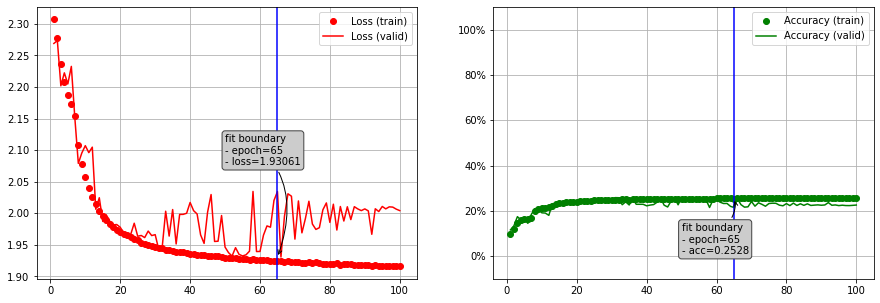

In [ ]:
plot_history(
    Experiment(train_hyperparams)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .add_layer(10, activation="relu")
        .build()
    )
    .run()
)


## Step 6. Overfitting Model

`<tbd>`


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 256)               786688    
                                                                 
 x1 (Dense)                  (None, 256)               65792     
                                                                 
 y_hat (Dense)               (None, 10)                2570      
                                                                 
Total params: 855,050
Trainable params: 855,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [==============================] - 21s 243ms/step - loss: 2.3692 - acc: 0.1895 - val_loss: 2.1087 - val_acc: 0.2422
Epoch 2/100
79/79 [==============================] - 5s 62ms/step - loss: 1.9950 - acc: 0.2767 - val_loss: 2.0923 - val_acc: 0.2679
Epoch 3/100
79/79 [===========================

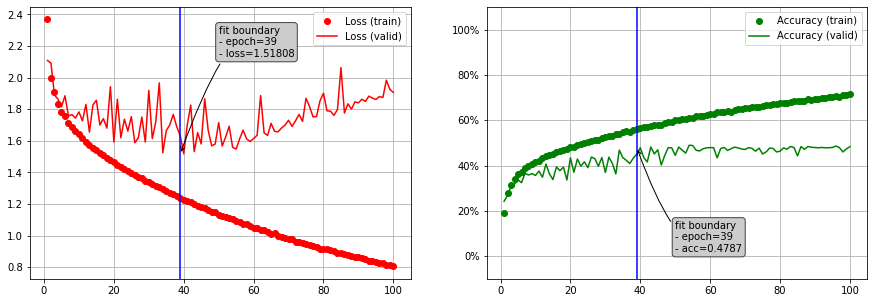

In [ ]:
plot_history(
    Experiment(train_hyperparams)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .add_layer(256, activation="relu")
        .add_layer(256, activation="relu")
        .build()
    )
    .run()
)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 512)               1573376   
                                                                 
 x1 (Dense)                  (None, 512)               262656    
                                                                 
 y_hat (Dense)               (None, 10)                5130      
                                                                 
Total params: 1,841,162
Trainable params: 1,841,162
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [==============================] - 22s 267ms/step - loss: 2.7397 - acc: 0.1798 - val_loss: 2.0563 - val_acc: 0.2414
Epoch 2/100
79/79 [==============================] - 11s 136ms/step - loss: 2.0250 - acc: 0.2633 - val_loss: 2.1043 - val_acc: 0.2373
Epoch 3/100
79/79 [=====================

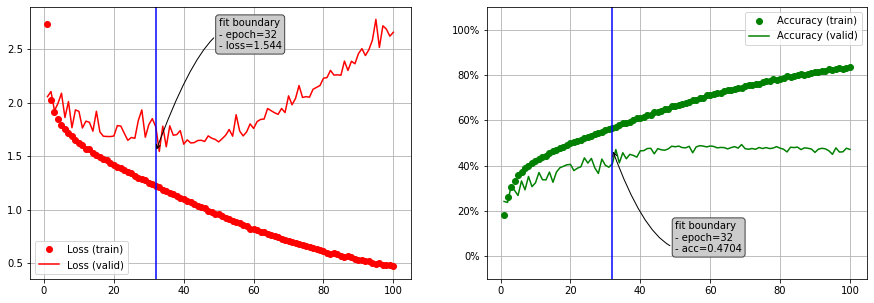

In [ ]:
plot_history(
    Experiment(train_hyperparams)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .add_layer(512, activation="relu")
        .add_layer(512, activation="relu")
        .build()
    )
    .run()
)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 1024)              3146752   
                                                                 
 x1 (Dense)                  (None, 1024)              1049600   
                                                                 
 y_hat (Dense)               (None, 10)                10250     
                                                                 
Total params: 4,206,602
Trainable params: 4,206,602
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [==============================] - 34s 416ms/step - loss: 2.7558 - acc: 0.1835 - val_loss: 2.1286 - val_acc: 0.2126
Epoch 2/100
79/79 [==============================] - 22s 276ms/step - loss: 2.0065 - acc: 0.2666 - val_loss: 1.8938 - val_acc: 0.3116
Epoch 3/100
79/79 [====================

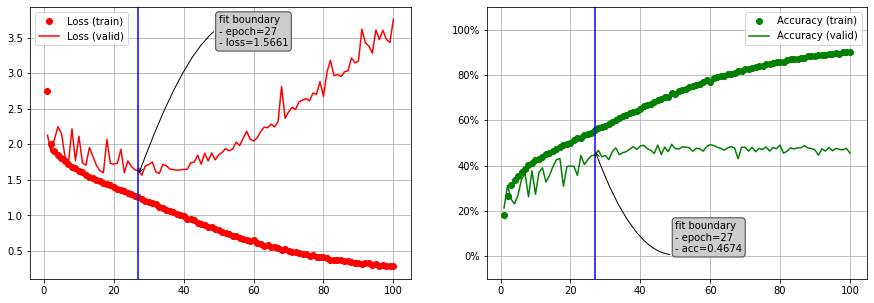

In [ ]:
plot_history(
    Experiment(train_hyperparams)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .add_layer(1024, activation="relu")
        .add_layer(1024, activation="relu")
        .build()
    )
    .run()
)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 2048)              6293504   
                                                                 
 x1 (Dense)                  (None, 2048)              4196352   
                                                                 
 y_hat (Dense)               (None, 10)                20490     
                                                                 
Total params: 10,510,346
Trainable params: 10,510,346
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [==============================] - 75s 946ms/step - loss: 3.0785 - acc: 0.1737 - val_loss: 2.0376 - val_acc: 0.2345
Epoch 2/100
79/79 [==============================] - 56s 706ms/step - loss: 2.0235 - acc: 0.2585 - val_loss: 1.9418 - val_acc: 0.2802
Epoch 3/100
79/79 [==================

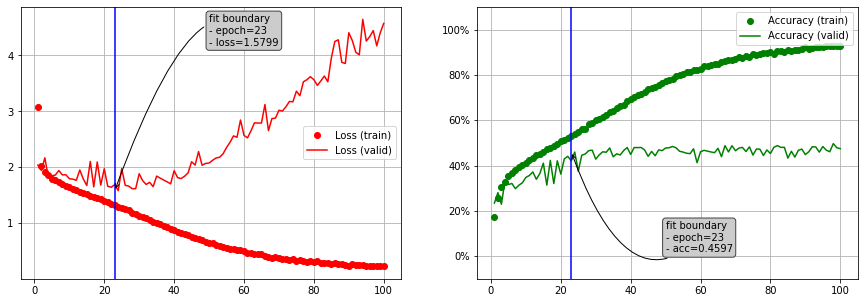

In [ ]:
plot_history(
    Experiment(train_hyperparams)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .add_layer(2048, activation="relu")
        .add_layer(2048, activation="relu")
        .build()
    )
    .run()
)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 4096)              12587008  
                                                                 
 x1 (Dense)                  (None, 4096)              16781312  
                                                                 
 y_hat (Dense)               (None, 10)                40970     
                                                                 
Total params: 29,409,290
Trainable params: 29,409,290
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [==============================] - 221s 3s/step - loss: 3.9266 - acc: 0.1617 - val_loss: 2.0609 - val_acc: 0.2335
Epoch 2/100
79/79 [==============================] - 215s 3s/step - loss: 2.0388 - acc: 0.2576 - val_loss: 1.9687 - val_acc: 0.2824
Epoch 3/100
79/79 [======================

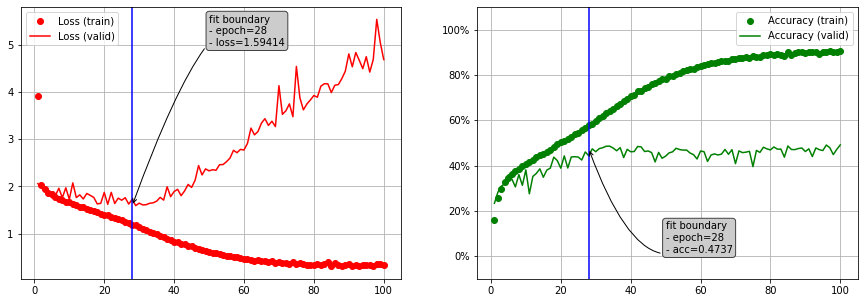

In [ ]:
plot_history(
    Experiment(train_hyperparams)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .add_layer(4096, activation="relu")
        .add_layer(4096, activation="relu")
        .build()
    )
    .run()
)


## Step 7. Model Tuning

`<tbd>`


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 2048)              6293504   
                                                                 
 y_hat (Dense)               (None, 10)                20490     
                                                                 
Total params: 6,313,994
Trainable params: 6,313,994
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/100
79/79 [==============================] - 47s 583ms/step - loss: 4.1609 - acc: 0.1886 - val_loss: 2.2479 - val_acc: 0.1794
Epoch 2/100
79/79 [==============================] - 28s 357ms/step - loss: 2.0558 - acc: 0.2619 - val_loss: 2.0462 - val_acc: 0.2515
Epoch 3/100
79/79 [==============================] - 29s 370ms/step - loss: 1.9405 - acc: 0.3044 - val_loss: 1.9683 - val_acc: 0.2936
Epoch 4/100
79/79 [==============================] - 29s 365ms/step - loss: 1.8697 - acc: 0.3302 - val_loss: 1.8439 - val_acc: 0.3221
Epoch 5/100
79/79 [==============================] - 29s 368ms/step - loss: 1.8128 - acc: 0.3537 - val_loss: 1.9264 - val_acc: 0.2946
Epoch 6/100
79/79 [==============================] - 29s 368ms/step - loss: 1.7718 - acc: 0.3686 - val_loss: 1.7737 - val_acc: 0.3563
Epoch 7/100
79/79 [==============================] - 29s 365ms/step - loss: 1.7393 - acc: 0.3820 - val_loss: 1.8492 - val_acc: 0.3293
Epoch 8/100
79/79 [==============================] - 29s 366ms

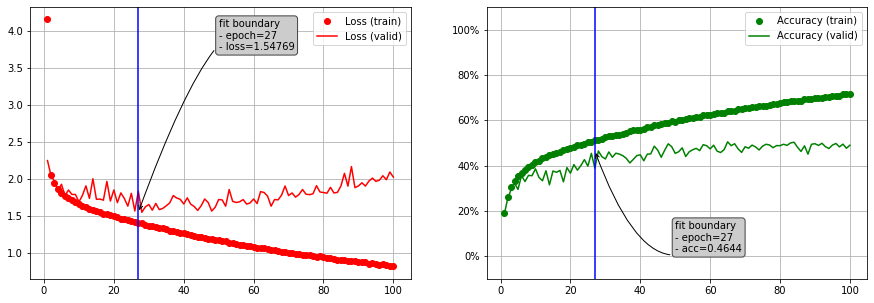

In [ ]:
plot_history(
    Experiment(train_hyperparams)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .add_layer(2048, activation="relu")
        .build()
    )
    .run()
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 2048)              6293504   
                                                                 
 y_hat (Dense)               (None, 10)                20490     
                                                                 
Total params: 6,313,994
Trainable params: 6,313,994
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [==============================] - 51s 643ms/step - loss: 11.9473 - acc: 0.1723 - val_loss: 3.3181 - val_acc: 0.1308
Epoch 2/100
79/79 [==============================] - 38s 475ms/step - loss: 2.5166 - acc: 0.2161 - val_loss: 2.1976 - val_acc: 0.2516
Epoch 3/100
79/79 [==============================] - 29s 373ms/step - loss: 2.1772 - acc: 0.2520 - val_loss: 2.1610 - val_acc: 0.2387
Epoch 4/100
79/79 [==================

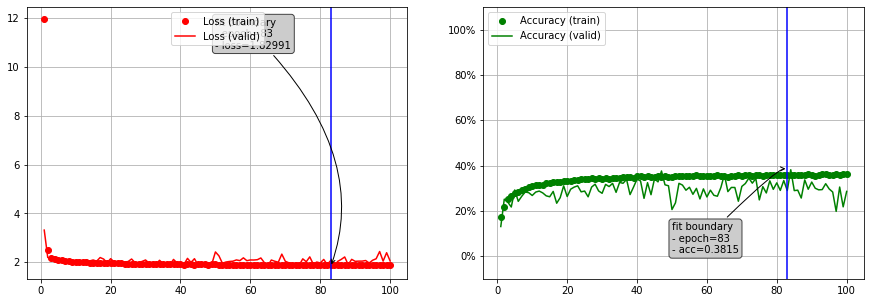

In [ ]:
plot_history(
    Experiment(train_hyperparams)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .add_layer(2048, activation="relu", regularization="l2")
        .build()
    )
    .run()
)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 2048)              6293504   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 y_hat (Dense)               (None, 10)                20490     
                                                                 
Total params: 6,313,994
Trainable params: 6,313,994
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [==============================] - 40s 494ms/step - loss: 3.4575 - acc: 0.1826 - val_loss: 2.2249 - val_acc: 0.2100
Epoch 2/100
79/79 [==============================] - 29s 366ms/step - loss: 2.0611 - acc: 0.2507 - val_loss: 1.9650 - val_acc: 0.2827
Epoch 3/100
79/79 [=====================

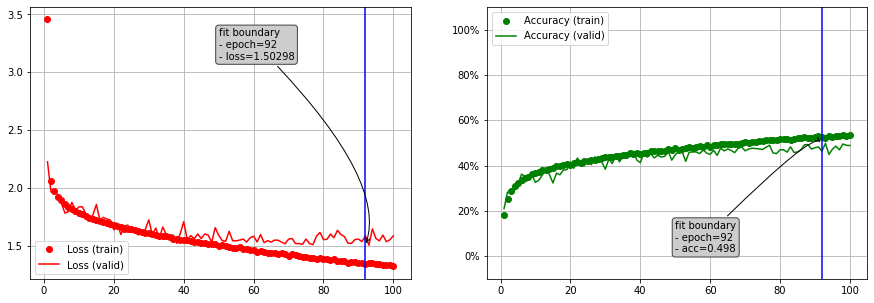

In [ ]:
plot_history(
    Experiment(train_hyperparams)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .add_layer(2048, activation="relu", dropout=0.5)
        .build()
    )
    .run()
)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 2048)              6293504   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 y_hat (Dense)               (None, 10)                20490     
                                                                 
Total params: 6,313,994
Trainable params: 6,313,994
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [==============================] - 41s 510ms/step - loss: 10.5414 - acc: 0.1577 - val_loss: 2.7264 - val_acc: 0.1894
Epoch 2/100
79/79 [==============================] - 30s 379ms/step - loss: 2.3549 - acc: 0.2054 - val_loss: 2.1400 - val_acc: 0.2712
Epoch 3/100
79/79 [====================

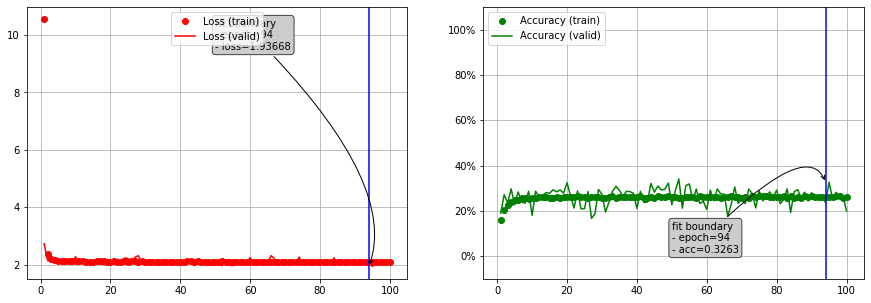

In [ ]:
plot_history(
    Experiment(train_hyperparams)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .add_layer(2048, activation="relu", regularization="l2", dropout=0.5)
        .build()
    )
    .run()
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 2048)              6293504   
                                                                 
 x1 (Dense)                  (None, 2048)              4196352   
                                                                 
 y_hat (Dense)               (None, 10)                20490     
                                                                 
Total params: 10,510,346
Trainable params: 10,510,346
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [==============================] - 69s 863ms/step - loss: 13.8900 - acc: 0.1653 - val_loss: 2.9339 - val_acc: 0.1950
Epoch 2/100
79/79 [==============================] - 55s 692ms/step - loss: 2.2502 - acc: 0.2488 - val_loss: 2.0230 - val_acc: 0.3065
Epoch 3/100
79/79 [==================

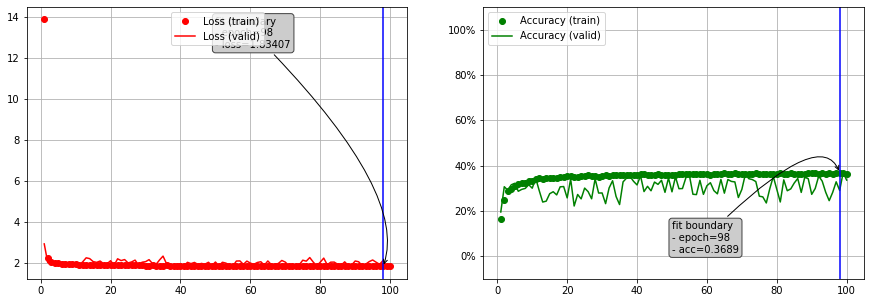

In [ ]:
plot_history(
    Experiment(train_hyperparams)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .add_layer(2048, activation="relu", regularization="l2")
        .add_layer(2048, activation="relu", regularization="l2")
        .build()
    )
    .run()
)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 2048)              6293504   
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 x1 (Dense)                  (None, 2048)              4196352   
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 y_hat (Dense)               (None, 10)                20490     
                                                                 
Total params: 10,510,346
Trainable params: 10,510,346
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [=======================

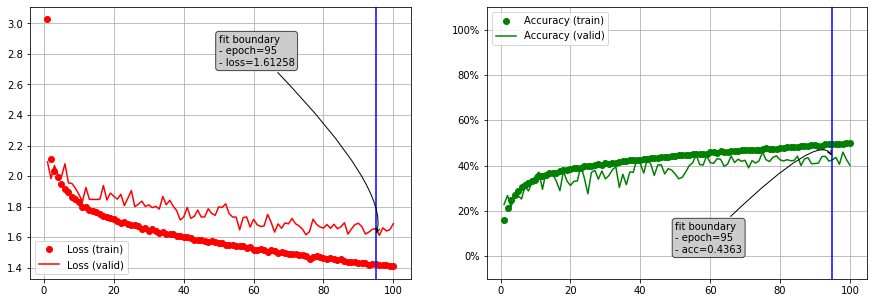

In [ ]:
plot_history(
    Experiment(train_hyperparams)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .add_layer(2048, activation="relu", dropout=0.5)
        .add_layer(2048, activation="relu", dropout=0.5)
        .build()
    )
    .run()
)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 2048)              6293504   
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 x1 (Dense)                  (None, 2048)              4196352   
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 y_hat (Dense)               (None, 10)                20490     
                                                                 
Total params: 10,510,346
Trainable params: 10,510,346
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [=======================

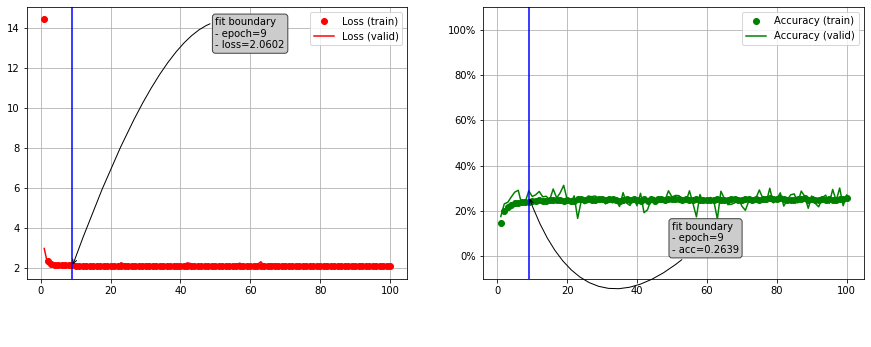

In [ ]:
plot_history(
    Experiment(train_hyperparams)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .add_layer(2048, activation="relu", regularization="l2", dropout=0.5)
        .add_layer(2048, activation="relu", regularization="l2", dropout=0.5)
        .build()
    )
    .run()
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 2048)              6293504   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 x1 (Dense)                  (None, 2048)              4196352   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 y_hat (Dense)               (None, 10)                20490     
                                                                 
Total params: 10,510,346
Trainable params: 10,510,346
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/100
79/79 [==============================] - 99s 1s/step - loss: 14.2005 - acc: 0.1541 - val_loss: 2.9800 - val_acc: 0.2040
Epoch 2/100
79/79 [==============================] - 66s 837ms/step - loss: 2.3097 - acc: 0.2285 - val_loss: 2.0777 - val_acc: 0.2459
Epoch 3/100
79/79 [==============================] - 65s 825ms/step - loss: 2.1137 - acc: 0.2532 - val_loss: 2.0343 - val_acc: 0.2770
Epoch 4/100
79/79 [==============================] - 71s 903ms/step - loss: 2.0892 - acc: 0.2635 - val_loss: 1.9901 - val_acc: 0.2988
Epoch 5/100
79/79 [==============================] - 64s 807ms/step - loss: 2.0637 - acc: 0.2753 - val_loss: 1.9701 - val_acc: 0.3182
Epoch 6/100
79/79 [==============================] - 63s 798ms/step - loss: 2.0555 - acc: 0.2808 - val_loss: 1.9904 - val_acc: 0.2969
Epoch 7/100
79/79 [==============================] - 63s 800ms/step - loss: 2.0454 - acc: 0.2816 - val_loss: 1.9826 - val_acc: 0.3219
Epoch 8/100
79/79 [==============================] - 64s 817ms/s

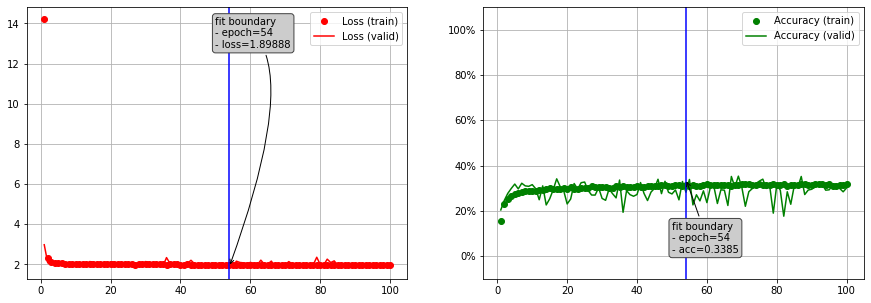

In [ ]:
plot_history(
    Experiment(train_hyperparams)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .add_layer(2048, activation="relu", regularization="l2", dropout=0.2)
        .add_layer(2048, activation="relu", regularization="l2", dropout=0.2)
        .build()
    )
    .run()
)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 2048)              6293504   
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 x1 (Dense)                  (None, 2048)              4196352   
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 y_hat (Dense)               (None, 10)                20490     
                                                                 
Total params: 10,510,346
Trainable params: 10,510,346
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [=======================

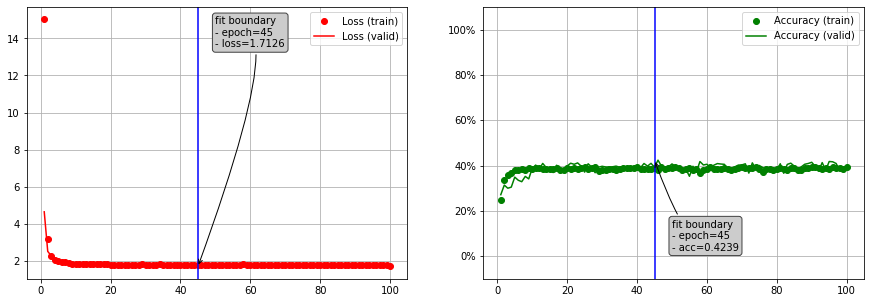

In [ ]:
plot_history(
    Experiment(train_hyperparams)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .with_optimizer("adam")
        .add_layer(2048, activation="relu", regularization="l2", dropout=0.2)
        .add_layer(2048, activation="relu", regularization="l2", dropout=0.2)
        .build()
    )
    .run()
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 2048)              6293504   
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 x1 (Dense)                  (None, 2048)              4196352   
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 y_hat (Dense)               (None, 10)                20490     
                                                                 
Total params: 10,510,346
Trainable params: 10,510,346
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [=======================

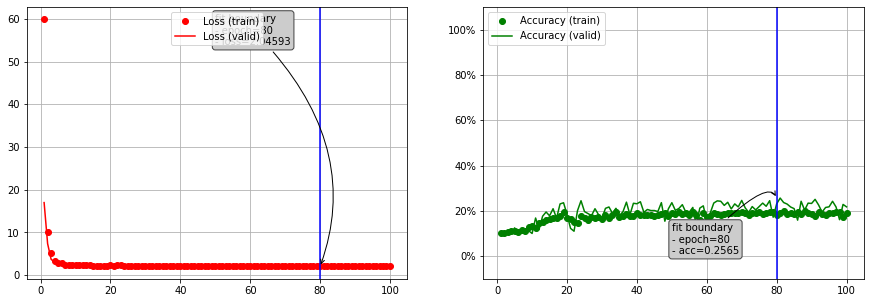

In [ ]:
plot_history(
    Experiment(train_hyperparams)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .with_optimizer(optimizers.Adam(learning_rate=0.01))
        .add_layer(2048, activation="relu", regularization="l2", dropout=0.2)
        .add_layer(2048, activation="relu", regularization="l2", dropout=0.2)
        .build()
    )
    .run()
)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 2048)              6293504   
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 x1 (Dense)                  (None, 2048)              4196352   
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                                 
 y_hat (Dense)               (None, 10)                20490     
                                                                 
Total params: 10,510,346
Trainable params: 10,510,346
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [=======================

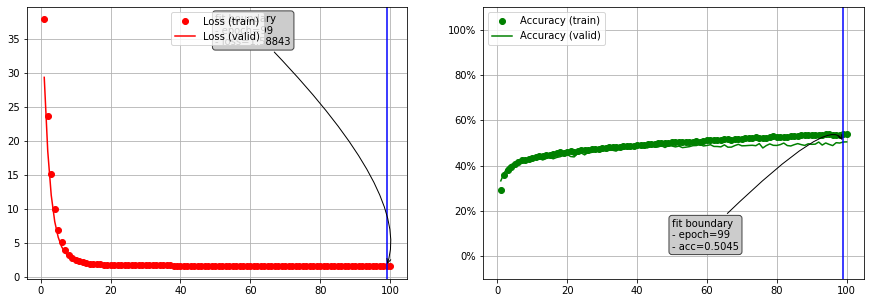

In [ ]:
plot_history(
    Experiment(train_hyperparams)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .with_optimizer(optimizers.Adam(learning_rate=0.0001))
        .add_layer(2048, activation="relu", regularization="l2", dropout=0.2)
        .add_layer(2048, activation="relu", regularization="l2", dropout=0.2)
        .build()
    )
    .run()
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 2048)              6293504   
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 x1 (Dense)                  (None, 2048)              4196352   
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 y_hat (Dense)               (None, 10)                20490     
                                                                 
Total params: 10,510,346
Trainable params: 10,510,346
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/225
79/79 [==============================] - 76s 924ms/step - loss: 37.9114 - acc: 0.2899 - val_loss: 29.3662 - val_acc: 0.3324
Epoch 2/225
79/79 [==============================] - 62s 785ms/step - loss: 23.6230 - acc: 0.3593 - val_loss: 18.5099 - val_acc: 0.3685
Epoch 3/225
79/79 [==============================] - 63s 804ms/step - loss: 15.0680 - acc: 0.3808 - val_loss: 12.0006 - val_acc: 0.3928
Epoch 4/225
79/79 [==============================] - 64s 818ms/step - loss: 9.9569 - acc: 0.3949 - val_loss: 8.1206 - val_acc: 0.4051
Epoch 5/225
79/79 [==============================] - 67s 854ms/step - loss: 6.8989 - acc: 0.4054 - val_loss: 5.8008 - val_acc: 0.4095
Epoch 6/225
79/79 [==============================] - 63s 798ms/step - loss: 5.0584 - acc: 0.4148 - val_loss: 4.3879 - val_acc: 0.4200
Epoch 7/225
79/79 [==============================] - 63s 799ms/step - loss: 3.9326 - acc: 0.4227 - val_loss: 3.5197 - val_acc: 0.4240
Epoch 8/225
79/79 [==============================] - 63s

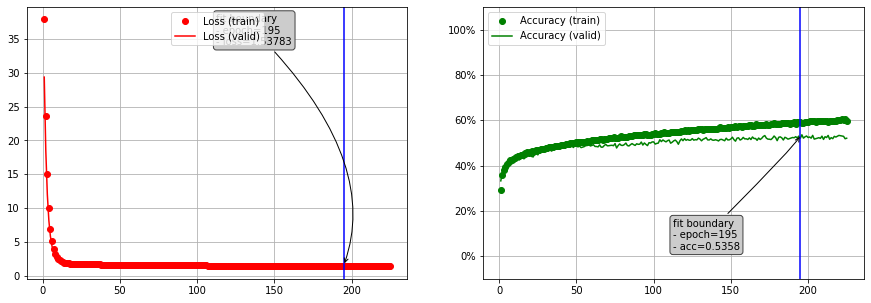

In [ ]:
plot_history(
    Experiment(train_hyperparams, epochs=225)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .with_optimizer(optimizers.Adam(learning_rate=0.0001))
        .add_layer(2048, activation="relu", regularization="l2", dropout=0.2)
        .add_layer(2048, activation="relu", regularization="l2", dropout=0.2)
        .build()
    )
    .run()
)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 4096)              12587008  
                                                                 
 dropout_18 (Dropout)        (None, 4096)              0         
                                                                 
 x1 (Dense)                  (None, 4096)              16781312  
                                                                 
 dropout_19 (Dropout)        (None, 4096)              0         
                                                                 
 y_hat (Dense)               (None, 10)                40970     
                                                                 
Total params: 29,409,290
Trainable params: 29,409,290
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
79/79 [=======================

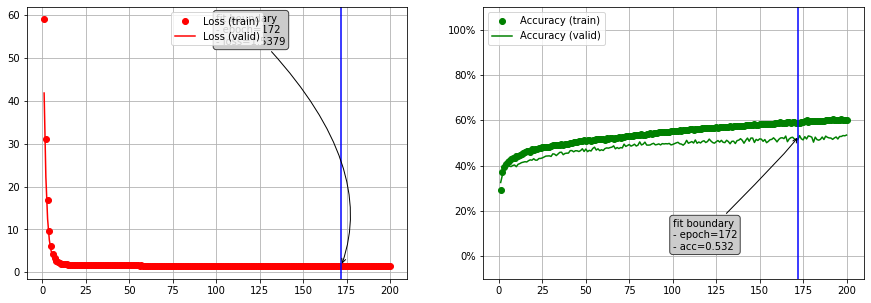

In [40]:
plot_history(
    Experiment(train_hyperparams, epochs=200)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .with_optimizer(optimizers.Adam(learning_rate=0.0001))
        .add_layer(4096, activation="relu", regularization="l2", dropout=0.2)
        .add_layer(4096, activation="relu", regularization="l2", dropout=0.2)
        .build()
    )
    .run()
)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 2048)              6293504   
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 x1 (Dense)                  (None, 2048)              4196352   
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 y_hat (Dense)               (None, 10)                20490     
                                                                 
Total params: 10,510,346
Trainable params: 10,510,346
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [=======================

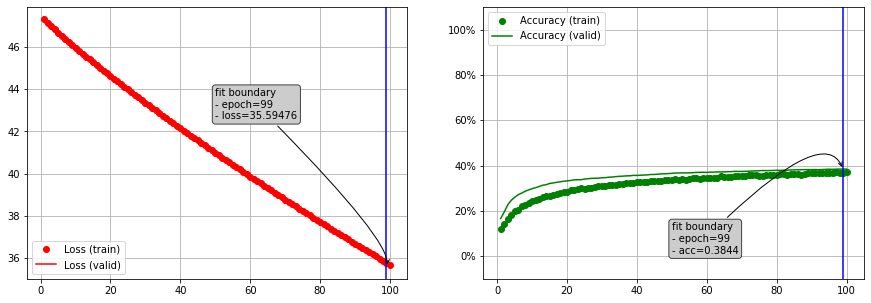

In [ ]:
# https://github.com/adhishthite/cifar10-optimizers
plot_history(
    Experiment(train_hyperparams)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .with_optimizer("adadelta")
        .add_layer(2048, activation="relu", regularization="l2", dropout=0.2)
        .add_layer(2048, activation="relu", regularization="l2", dropout=0.2)
        .build()
    )
    .run()
)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 2048)              6293504   
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 x1 (Dense)                  (None, 2048)              4196352   
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                                 
 y_hat (Dense)               (None, 10)                20490     
                                                                 
Total params: 10,510,346
Trainable params: 10,510,346
Non-trainable params: 0
_________________________________________________________________
Epoch 1/225
79/79 [=======================

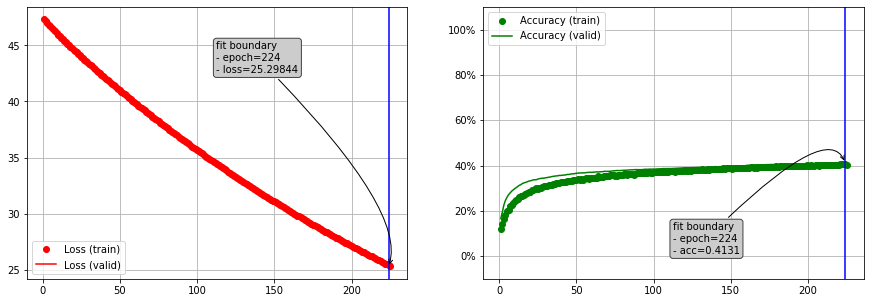

In [ ]:
# https://github.com/adhishthite/cifar10-optimizers
plot_history(
    Experiment(train_hyperparams, epochs=225)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_data())
    .with_valid_data(get_validation_data())
    .with_model(
        ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
        .with_optimizer("adadelta")
        .add_layer(2048, activation="relu", regularization="l2", dropout=0.2)
        .add_layer(2048, activation="relu", regularization="l2", dropout=0.2)
        .build()
    )
    .run()
)


## Final Model


In [22]:
final_dir = "/content/drive/MyDrive/Models/2023-02-25_CM3015_MLNN"


In [23]:
final_model = (
    ModelBuilder(input_dims=ds_image_dims, n_classes=ds_classes)
    .with_optimizer(optimizers.Adam(learning_rate=0.0001))
    .add_layer(2048, activation="relu", regularization="l2", dropout=0.2)
    .add_layer(2048, activation="relu", regularization="l2", dropout=0.2)
    .build()
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x0 (Dense)                  (None, 2048)              6293504   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 x1 (Dense)                  (None, 2048)              4196352   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 y_hat (Dense)               (None, 10)                20490     
                                                                 
Total params: 10,510,346
Trainable params: 10,510,346
Non-trainable params: 0
_________________________________________________________________


In [24]:
final_history = (
    Experiment(train_hyperparams, epochs=195)
    .with_preprocessor(preprocessing_fn)
    .with_train_data(get_training_and_validation_data())
    .with_model(final_model)
    .enable_log_tensorboard(os.path.join(final_dir, "logs/tensorboard"))
    .enable_log_csv(os.path.join(final_dir, "logs/training/final_model.csv"))
    .run()
)


Epoch 1/195
98/98 [==============================] - 82s 823ms/step - loss: 35.9187 - acc: 0.3019
Epoch 2/195
98/98 [==============================] - 71s 719ms/step - loss: 20.0532 - acc: 0.3703
Epoch 3/195
98/98 [==============================] - 71s 722ms/step - loss: 11.6604 - acc: 0.3937
Epoch 4/195
98/98 [==============================] - 68s 699ms/step - loss: 7.2415 - acc: 0.4060
Epoch 5/195
98/98 [==============================] - 70s 711ms/step - loss: 4.8965 - acc: 0.4178
Epoch 6/195
98/98 [==============================] - 69s 707ms/step - loss: 3.6161 - acc: 0.4265
Epoch 7/195
98/98 [==============================] - 67s 686ms/step - loss: 2.8951 - acc: 0.4309
Epoch 8/195
98/98 [==============================] - 68s 688ms/step - loss: 2.4722 - acc: 0.4357
Epoch 9/195
98/98 [==============================] - 72s 737ms/step - loss: 2.2121 - acc: 0.4426
Epoch 10/195
98/98 [==============================] - 73s 743ms/step - loss: 2.0515 - acc: 0.4457
Epoch 11/195
98/98 [======

In [25]:
#final_model.save(os.path.join(final_dir, "saved_model"))
final_model = models.load_model(os.path.join(final_dir, "saved_model"))

In [1]:
final_model.evaluate(get_test_data()
  .map(preprocessing_fn)
  .cache()
  .batch(512))

20/20 [==============================] - 9s 423ms/step - loss: 1.5055 - acc: 0.5424
[1.505475640296936, 0.5424000024795532]


## Results

`<tbd>`


## Conclusion

`<tbd>`


## References

[1]
```
@book{franoischollet2017learning,
  added-at = {2018-08-01T08:16:18.000+0200},
  author = {Chollet, François},
  biburl = {https://www.bibsonomy.org/bibtex/231f94815ebbd65d3a31e4a69e818573e/jaeschke},
  interhash = {cfbfd3f93853a469e5e6978f61a74a0a},
  intrahash = {31f94815ebbd65d3a31e4a69e818573e},
  isbn = {9781617294433},
  keywords = {ai deep deeplearning learning ml},
  month = nov,
  publisher = {Manning},
  timestamp = {2021-05-19T08:35:34.000+0200},
  title = {Deep Learning with Python },
  year = 2017
}
```

[2]
```
@INPROCEEDINGS{546912,
  author={Tumer, K. and Ghosh, J.},
  booktitle={Proceedings of 13th International Conference on Pattern Recognition}, 
  title={Estimating the Bayes error rate through classifier combining}, 
  year={1996},
  volume={2},
  number={},
  pages={695-699 vol.2},
  doi={10.1109/ICPR.1996.546912}}
```

[3]
```
@INPROCEEDINGS{9777354,
  author={Chen, Yifan and Wang, Shuang and Ge, Yunpeng},
  booktitle={2022 IEEE Asia-Pacific Conference on Image Processing, Electronics and Computers (IPEC)}, 
  title={A Survey on the Applications of Image Classification Based on Convolution Neural Network}, 
  year={2022},
  volume={},
  number={},
  pages={381-384},
  doi={10.1109/IPEC54454.2022.9777354}}
  ```

[4]
```
@TECHREPORT{Krizhevsky09learningmultiple,
    author = {Alex Krizhevsky},
    title = {Learning multiple layers of features from tiny images},
    institution = {},
    year = {2009}
}
```

[5]
```
@misc{https://doi.org/10.48550/arxiv.2204.08610,
  doi = {10.48550/ARXIV.2204.08610},
  url = {https://arxiv.org/abs/2204.08610},
  author = {Yang, Suorong and Xiao, Weikang and Zhang, Mengcheng and Guo, Suhan and Zhao, Jian and Shen, Furao},
  keywords = {Computer Vision and Pattern Recognition (cs.CV), FOS: Computer and information sciences, FOS: Computer and information sciences},
  title = {Image Data Augmentation for Deep Learning: A Survey},
  publisher = {arXiv},
  year = {2022},
  copyright = {Creative Commons Attribution 4.0 International}
}
```

[6]
```
@misc{https://doi.org/10.48550/arxiv.1805.07836,
  doi = {10.48550/ARXIV.1805.07836},
  url = {https://arxiv.org/abs/1805.07836},
  author = {Zhang, Zhilu and Sabuncu, Mert R.},
  keywords = {Machine Learning (cs.LG), Computer Vision and Pattern Recognition (cs.CV), Machine Learning (stat.ML), FOS: Computer and information sciences, FOS: Computer and information sciences},
  title = {Generalized Cross Entropy Loss for Training Deep Neural Networks with Noisy Labels},
  publisher = {arXiv},
  year = {2018},
  copyright = {arXiv.org perpetual, non-exclusive license}
}
```

In [ ]:
%%shelljupyter nbconvert --to html 'CM3015, MLNN, End of term coursework submission [002].ipynb'